# Unit Price Predictions

Prediction models to be developed:
- Unit price predictor

In [2]:
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import decomposition, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

from keys import conn_str

In [3]:
# import data
df = pd.read_sql_table('eda', conn_str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13493 entries, 0 to 13492
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Created                  13493 non-null  datetime64[ns]
 1   index                    13493 non-null  int64         
 2   Number                   13493 non-null  object        
 3   Date                     13493 non-null  object        
 4   Gross                    13493 non-null  float64       
 5   InvoiceID                13493 non-null  object        
 6   PointsEarned             13493 non-null  float64       
 7   Variants.NettPrice       13493 non-null  float64       
 8   Variants.DiscountAmount  13493 non-null  float64       
 9   Variants.Discount        13493 non-null  float64       
 10  Variants.PriceOriginal   13493 non-null  float64       
 11  Variants.Price           13493 non-null  float64       
 12  Variants.Cost            13493 n

In [4]:
df.drop(['Count' ,'Payments.Date', 'PointsEarned', 'Date', 'Variants.Code', 'Payments.Note', 'Payments.Code',
         'Variants.PriceOriginal', 'Gross'], axis=1, inplace=True)

In [5]:
df.isnull().sum()

Created                      0
index                        0
Number                       0
InvoiceID                    0
Variants.NettPrice           0
Variants.DiscountAmount      0
Variants.Discount            0
Variants.Price               0
Variants.Cost                0
Variants.Quantity            0
Variants.Name                0
Payments.Method              0
Payments.Amount              0
year                         0
month                        0
day                          0
dayOfWeek                    0
weekOfMonth                  0
hour                         0
minute                       0
LastPurchaseDate             0
Recency                      0
Frequency                    0
LastPurYear                  0
LastPurMonth                 0
LastPurDay                   0
weekDayOfLastPur             0
yearWeekOfLastPur            0
LastPurHour                  0
LastPurMinute                0
ItemTimeDiff                 1
ProductTimeDiff            260
GrossMar

In [6]:
df = df.rename(columns=
               {"Payments.Amount": "PaidAmount",
                "Payments.Method": "PaymentMethod",
                "Variants.Cost": "UnitCost",
                "Variants.Discount": "ProductDiscount",
                "Variants.DiscountAmount": "ProductDiscountAmount",
                "Variants.Name": "product",
                "Variants.NettPrice": "TotalPrice",
                "Variants.Price": "UnitPrice",
                "Variants.Quantity": "Quantity",
                "day": "Day",
                "hour": "Hour",
                "minute": "Minute",
                "month": "Month",
                "year": "Year",
                "Number": "number",
                "Created": "created",
                "InvoiceID": "invoiceid",
                "dayOfWeek": "DayOfWeek",
                "weekOfMonth": "WeekOfMonth",
                "LastPurchaseDate": "lastPurchaseDate",
                "weekDayOfLastPur": "WeekDayOfLastPur",
                "yearWeekOfLastPur": "WeekOfLastPur"
                })
df.head()

created  index     number  \
0 2020-02-07 22:51:30.473      0  20.02.002   
1 2020-02-07 22:52:50.140      1  20.02.003   
2 2020-02-07 22:53:26.450      2  20.02.004   
3 2020-02-07 23:05:02.100      3  20.02.005   
4 2020-02-07 23:05:02.100      3  20.02.005   

                              invoiceid  TotalPrice  ProductDiscountAmount  \
0  a4f938d7-a234-49f9-9588-ea6dc1b547b2       200.0                    0.0   
1  89681b1f-21ab-4f0a-8780-3971de3f82b0       400.0                    0.0   
2  af594745-e964-4051-ae17-93b23b746743       100.0                    0.0   
3  a76090aa-9470-4ef5-8e38-59568d23bdae       300.0                    0.0   
4  a76090aa-9470-4ef5-8e38-59568d23bdae        80.0                    0.0   

   ProductDiscount  UnitPrice  UnitCost  Quantity  ... WeekOfLastPur  \
0              0.0      200.0       0.0       1.0  ...            22   
1              0.0      200.0     120.0       2.0  ...            45   
2              0.0      100.0      75.0       1.0  ...            38   
3              0.0      300.0     183.0       1.0  ...            46   
4              0.0       80.0       0.0       1.0  ...             8   

  LastPurHour  LastPurMinute  ItemTimeDiff  ProductTimeDiff  GrossMargin  \
0          18             36           NaN              NaN        200.0   
1          21             13        79.667              NaN         80.0   
2          20             37        36.310              NaN         25.0   
3          20             26       695.650              NaN        117.0   
4          18             14         0.000              NaN         80.0   

   ProfitLoss  MarginPerc  MarginDeviation  DeviationType  
0      Profit    1.000000         0.000000       Negative  
1      Profit    0.666667         0.333333       Negative  
2      Profit    0.333333         0.666667       Negative  
3      Profit    0.639344         0.360656       Negative  
4      Profit    1.000000         0.000000       Negative  

[5 rows x 37 columns]

In [7]:
df = df.reindex(sorted(df.columns), axis=1)
df

Day  DayOfWeek DeviationType  Frequency  GrossMargin  Hour  \
0        7          4      Negative         87        200.0    22   
1        7          4      Negative         14         80.0    22   
2        7          4      Negative        130         25.0    22   
3        7          4      Negative         56        117.0    23   
4        7          4      Negative         11         80.0    23   
...    ...        ...           ...        ...          ...   ...   
13488   25          0      Positive        136         33.0    22   
13489   25          0      Negative         94        -24.0    22   
13490   25          0      Negative         43        -50.0    22   
13491   26          1      Negative         94        -24.0     0   
13492   26          1      Negative         43        -40.0     0   

       ItemTimeDiff  LastPurDay  LastPurHour  LastPurMinute  ...  \
0               NaN          30           18             36  ...   
1            79.667           2           21             13  ...   
2            36.310          20           20             37  ...   
3           695.650          10           20             26  ...   
4             0.000          17           18             14  ...   
...             ...         ...          ...            ...  ...   
13488      2266.426          25           22             22  ...   
13489         0.000          26            0              4  ...   
13490       669.430          26            0              4  ...   
13491      5446.000          26            0              4  ...   
13492         0.000          26            0              4  ...   

       WeekDayOfLastPur  WeekOfLastPur  WeekOfMonth  Year  \
0                     5             22            6  2020   
1                     0             45            6  2020   
2                     6             38            6  2020   
3                     1             46            6  2020   
4                     0              8            6  2020   
...                 ...            ...          ...   ...   
13488                 0              4            4  2021   
13489                 1              4            4  2021   
13490                 1              4            4  2021   
13491                 1              4            4  2021   
13492                 1              4            4  2021   

                      created  index                             invoiceid  \
0     2020-02-07 22:51:30.473      0  a4f938d7-a234-49f9-9588-ea6dc1b547b2   
1     2020-02-07 22:52:50.140      1  89681b1f-21ab-4f0a-8780-3971de3f82b0   
2     2020-02-07 22:53:26.450      2  af594745-e964-4051-ae17-93b23b746743   
3     2020-02-07 23:05:02.100      3  a76090aa-9470-4ef5-8e38-59568d23bdae   
4     2020-02-07 23:05:02.100      3  a76090aa-9470-4ef5-8e38-59568d23bdae   
...                       ...    ...                                   ...   
13488 2021-01-25 22:22:41.243   2750  746f97a4-947b-497b-830f-dd1d1c05394b   
13489 2021-01-25 22:22:41.243   2750  746f97a4-947b-497b-830f-dd1d1c05394b   
13490 2021-01-25 22:33:50.673   2751  7a2899db-2d87-46bc-a9c4-565d08df0d0d   
13491 2021-01-26 00:04:36.673   2752  5f82a83d-5547-4d20-9b5f-54f1d3b77493   
13492 2021-01-26 00:04:36.673   2752  5f82a83d-5547-4d20-9b5f-54f1d3b77493   

             lastPurchaseDate     number                      product  
0     2020-05-30 18:36:43.857  20.02.002     Ladies Dress 200bob 2001  
1     2020-11-02 21:13:17.210  20.02.003                 Men Trousers  
2     2020-09-20 20:37:31.790  20.02.004                  Men tshirts  
3     2020-11-10 20:26:25.740  20.02.005                Lady Hand bag  
4     2020-02-17 18:14:30.623  20.02.005  Children Jackets 80bob 3003  
...                       ...        ...                          ...  
13488 2021-01-25 22:22:41.243  21.01.513                  Cotton Tops  
13489 2021-01-26 00:04:36.673  21.01.513                     Velvet 4  
13490 2021-01-26 00:04:36.673  21.01.514   

We want to train the model to predict the unit price in a way that will lead to a profit where the margin percentage
will be as close to 1 as possible.

In [8]:
filter_df = df.loc[(df.MarginPerc <= 1) & (df.ProfitLoss == 'Profit')]
filter_df.head()

Day  DayOfWeek DeviationType  Frequency  GrossMargin  Hour  ItemTimeDiff  \
0    7          4      Negative         87        200.0    22           NaN   
1    7          4      Negative         14         80.0    22        79.667   
2    7          4      Negative        130         25.0    22        36.310   
3    7          4      Negative         56        117.0    23       695.650   
4    7          4      Negative         11         80.0    23         0.000   

   LastPurDay  LastPurHour  LastPurMinute  ...  WeekDayOfLastPur  \
0          30           18             36  ...                 5   
1           2           21             13  ...                 0   
2          20           20             37  ...                 6   
3          10           20             26  ...                 1   
4          17           18             14  ...                 0   

   WeekOfLastPur  WeekOfMonth  Year                 created  index  \
0             22            6  2020 2020-02-07 22:51:30.473      0   
1             45            6  2020 2020-02-07 22:52:50.140      1   
2             38            6  2020 2020-02-07 22:53:26.450      2   
3             46            6  2020 2020-02-07 23:05:02.100      3   
4              8            6  2020 2020-02-07 23:05:02.100      3   

                              invoiceid        lastPurchaseDate     number  \
0  a4f938d7-a234-49f9-9588-ea6dc1b547b2 2020-05-30 18:36:43.857  20.02.002   
1  89681b1f-21ab-4f0a-8780-3971de3f82b0 2020-11-02 21:13:17.210  20.02.003   
2  af594745-e964-4051-ae17-93b23b746743 2020-09-20 20:37:31.790  20.02.004   
3  a76090aa-9470-4ef5-8e38-59568d23bdae 2020-11-10 20:26:25.740  20.02.005   
4  a76090aa-9470-4ef5-8e38-59568d23bdae 2020-02-17 18:14:30.623  20.02.005   

                       product  
0     Ladies Dress 200bob 2001  
1                 Men Trousers  
2                  Men tshirts  
3                Lady Hand bag  
4  Children Jackets 80bob 3003  

[5 rows x 37 columns]

In [9]:
filter_df.drop(['created', 'index', 'invoiceid', 'lastPurchaseDate', 'number', 'Year', 'LastPurYear', 'DeviationType',
                'ProfitLoss'], inplace=True, axis=1)

/Users/erickamau/PycharmProjects/ADS/venv/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
fig = px.histogram(filter_df, x="UnitPrice")
fig.show()

In [11]:
filter_df.head().T

0             1            2  \
Day                                           7             7            7   
DayOfWeek                                     4             4            4   
Frequency                                    87            14          130   
GrossMargin                                 200            80           25   
Hour                                         22            22           22   
ItemTimeDiff                                NaN        79.667        36.31   
LastPurDay                                   30             2           20   
LastPurHour                                  18            21           20   
LastPurMinute                                36            13           37   
LastPurMonth                                  5            11            9   
MarginDeviation                               0      0.333333     0.666667   
MarginPerc                                    1      0.666667     0.333333   
Minute                                       51            52           53   
Month                                         2             2            2   
PaidAmount                                  200           400          100   
PaymentMethod                              Cash          Cash         Cash   
ProductDiscount                               0             0            0   
ProductDiscountAmount                         0             0            0   
ProductTimeDiff                             NaN           NaN          NaN   
Quantity                                      1             2            1   
Recency                                     240            84          127   
TotalPrice                                  200           400          100   
UnitCost                                      0           120           75   
UnitPrice                                   200           200          100   
WeekDayOfLastPur                              5             0            6   
WeekOfLastPur                                22            45           38   
WeekOfMonth                                   6             6            6   
product                Ladies Dress 200bob 2001  Men Trousers  Men tshirts   

                                   3                            4  
Day                                7                            7  
DayOfWeek                          4                            4  
Frequency                         56                           11  
GrossMargin                      117                           80  
Hour                              23                           23  
ItemTimeDiff                  695.65                            0  
LastPurDay                        10                           17  
LastPurHour                       20                           18  
LastPurMinute                     26                           14  
LastPurMonth                      11                            2  
MarginDeviation             0.360656                            0  
MarginPerc                  0.639344                            1  
Minute                             5                            5  
Month                              2                            2  
PaidAmount                       380                          380  
PaymentMethod                   Cash                         Cash  
ProductDiscount                    0                            0  
ProductDiscountAmount              0                            0  
ProductTimeDiff                  NaN                          NaN  
Quantity                           1                            1  
Recency                           76                          343  
TotalPrice                       300                           80  
UnitCost                         183                            0  
UnitPrice                        300                           80  
WeekDayOfLastPur                   1                            0  
WeekOfLastPur  

In [12]:
df_tmp = filter_df.copy()

## Data Prep

- Imputing missing values
- Encoding categorical variables

### Detecting categorical columns
Find the columns which contain strings then convert all string values into categorical data types

In [13]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

PaymentMethod
product


In [14]:
# turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [15]:
# identifying categorical variables in our data and placing them in a list
categorical = [var for var in filter_df.columns if filter_df[var].dtype=='object']

In [16]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6685 entries, 0 to 13487
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Day                    6685 non-null   int64   
 1   DayOfWeek              6685 non-null   int64   
 2   Frequency              6685 non-null   int64   
 3   GrossMargin            6685 non-null   float64 
 4   Hour                   6685 non-null   int64   
 5   ItemTimeDiff           6684 non-null   float64 
 6   LastPurDay             6685 non-null   int64   
 7   LastPurHour            6685 non-null   int64   
 8   LastPurMinute          6685 non-null   int64   
 9   LastPurMonth           6685 non-null   int64   
 10  MarginDeviation        6685 non-null   float64 
 11  MarginPerc             6685 non-null   float64 
 12  Minute                 6685 non-null   int64   
 13  Month                  6685 non-null   int64   
 14  PaidAmount             6685 non-null   

Checking numeric columns for missing / null values

In [17]:
# check numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

Day
DayOfWeek
Frequency
GrossMargin
Hour
ItemTimeDiff
LastPurDay
LastPurHour
LastPurMinute
LastPurMonth
MarginDeviation
MarginPerc
Minute
Month
PaidAmount
ProductDiscount
ProductDiscountAmount
ProductTimeDiff
Quantity
Recency
TotalPrice
UnitCost
UnitPrice
WeekDayOfLastPur
WeekOfLastPur
WeekOfMonth


In [18]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

ItemTimeDiff
ProductTimeDiff


In [19]:
numerical = [var for var in df_tmp.columns if df_tmp[var].dtype!="O" and var not in categorical]
print("{} numerical variables".format(len(numerical)))

26 numerical variables


In [20]:
# identifying temporal values
time_vars = [var for var in numerical if "Year" in var or "Month" in var
                 or "Week" in var or "Day" in var or "Hour" in var or "Minute" in var]

last_time_vars = [var for var in df_tmp if "Last" in var]

In [21]:
# identifying discrete values
discrete = []

for var in numerical:
    if len(df_tmp[var].unique())<20 and var not in time_vars:
        print(var, 'values: ', df[var].unique())
        discrete.append(var)

print('{} discrete variables'.format(len(discrete)))

ProductDiscount values:  [ 0. 20. 15. 10. 25.]
ProductDiscountAmount values:  [ 0. 50. 30. 60. 20.  5. 40.]
2 discrete variables


In [22]:
numerical = [var for var in numerical if var not in discrete and var not in time_vars and var not in categorical]
print(numerical)

['Frequency', 'GrossMargin', 'ItemTimeDiff', 'MarginDeviation', 'MarginPerc', 'PaidAmount', 'ProductTimeDiff', 'Quantity', 'Recency', 'TotalPrice', 'UnitCost', 'UnitPrice']


In [23]:
# dropping *previous* purchase time values from analysis
df_tmp.drop(columns=last_time_vars, inplace=True)
df_tmp.head()

Day  DayOfWeek  Frequency  GrossMargin  Hour  ItemTimeDiff  \
0    7          4         87        200.0    22           NaN   
1    7          4         14         80.0    22        79.667   
2    7          4        130         25.0    22        36.310   
3    7          4         56        117.0    23       695.650   
4    7          4         11         80.0    23         0.000   

   MarginDeviation  MarginPerc  Minute  Month  ...  ProductDiscount  \
0         0.000000    1.000000      51      2  ...              0.0   
1         0.333333    0.666667      52      2  ...              0.0   
2         0.666667    0.333333      53      2  ...              0.0   
3         0.360656    0.639344       5      2  ...              0.0   
4         0.000000    1.000000       5      2  ...              0.0   

  ProductDiscountAmount  ProductTimeDiff  Quantity  Recency  TotalPrice  \
0                   0.0              NaN       1.0      240       200.0   
1                   0.0              NaN       2.0       84       400.0   
2                   0.0              NaN       1.0      127       100.0   
3                   0.0              NaN       1.0       76       300.0   
4                   0.0              NaN       1.0      343        80.0   

   UnitCost  UnitPrice  WeekOfMonth                      product  
0       0.0      200.0            6     Ladies Dress 200bob 2001  
1     120.0      200.0            6                 Men Trousers  
2      75.0      100.0            6                  Men tshirts  
3     183.0      300.0            6                Lady Hand bag  
4       0.0       80.0            6  Children Jackets 80bob 3003  

[5 rows x 22 columns]

The missing values arise from calculation of the item and product purchase interval. Since it's trying to calculate the
interval between itself, we can fill the values with 0.

In [24]:
df_tmp['ItemTimeDiff'].fillna(value=0.0, inplace=True)
df_tmp['ProductTimeDiff'].fillna(value=0.0, inplace=True)
df_tmp.head()

Day  DayOfWeek  Frequency  GrossMargin  Hour  ItemTimeDiff  \
0    7          4         87        200.0    22         0.000   
1    7          4         14         80.0    22        79.667   
2    7          4        130         25.0    22        36.310   
3    7          4         56        117.0    23       695.650   
4    7          4         11         80.0    23         0.000   

   MarginDeviation  MarginPerc  Minute  Month  ...  ProductDiscount  \
0         0.000000    1.000000      51      2  ...              0.0   
1         0.333333    0.666667      52      2  ...              0.0   
2         0.666667    0.333333      53      2  ...              0.0   
3         0.360656    0.639344       5      2  ...              0.0   
4         0.000000    1.000000       5      2  ...              0.0   

  ProductDiscountAmount  ProductTimeDiff  Quantity  Recency  TotalPrice  \
0                   0.0              0.0       1.0      240       200.0   
1                   0.0              0.0       2.0       84       400.0   
2                   0.0              0.0       1.0      127       100.0   
3                   0.0              0.0       1.0       76       300.0   
4                   0.0              0.0       1.0      343        80.0   

   UnitCost  UnitPrice  WeekOfMonth                      product  
0       0.0      200.0            6     Ladies Dress 200bob 2001  
1     120.0      200.0            6                 Men Trousers  
2      75.0      100.0            6                  Men tshirts  
3     183.0      300.0            6                Lady Hand bag  
4       0.0       80.0            6  Children Jackets 80bob 3003  

[5 rows x 22 columns]

In [25]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Converting categorical values to numeric using label and one hot encoding

In [26]:
df_tmp = df_tmp.set_index('product')

In [27]:
onehot = OneHotEncoder(sparse=False, handle_unknown='error')
nominal = onehot.fit_transform(df_tmp[['PaymentMethod']])
df_nominal = pd.DataFrame(index=df_tmp.index, data=nominal, columns=onehot.get_feature_names(['PaymentMethod']))
df_nominal.head()

PaymentMethod_Cash  PaymentMethod_MPESA
product                                                             
Ladies Dress 200bob 2001                    1.0                  0.0
Men Trousers                                1.0                  0.0
Men tshirts                                 1.0                  0.0
Lady Hand bag                               1.0                  0.0
Children Jackets 80bob 3003                 1.0                  0.0

In [28]:
df_tmp = pd.concat([df_tmp, df_nominal], axis=1)
df_tmp.drop(columns=['PaymentMethod'], inplace=True)
df_tmp.shape

(6685, 22)

In [29]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes+1

In [30]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 6685 entries, Ladies Dress 200bob 2001 to paper bags
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Day                    6685 non-null   int64  
 1   DayOfWeek              6685 non-null   int64  
 2   Frequency              6685 non-null   int64  
 3   GrossMargin            6685 non-null   float64
 4   Hour                   6685 non-null   int64  
 5   ItemTimeDiff           6685 non-null   float64
 6   MarginDeviation        6685 non-null   float64
 7   MarginPerc             6685 non-null   float64
 8   Minute                 6685 non-null   int64  
 9   Month                  6685 non-null   int64  
 10  PaidAmount             6685 non-null   float64
 11  ProductDiscount        6685 non-null   float64
 12  ProductDiscountAmount  6685 non-null   float64
 13  ProductTimeDiff        6685 non-null   float64
 14  Quantity             

In [31]:
nan_check = df_tmp.isna().sum()

In [32]:
X = df_tmp.drop("UnitPrice", axis=1)
y = df_tmp["UnitPrice"]

# Minimizing Outliers

Interquartile range used to minimize outliers

In [33]:
px.box(y)

In [34]:
def remove_outlier(col):
    q25 = col.quantile(0.25)
    q75 = col.quantile(0.75)
    iqr = q75 - q25
    cutoff = iqr*1.5
    lower = q25 - cutoff
    upper = q75 + cutoff
    return lower, upper

lower, upper = remove_outlier(df_tmp.UnitPrice)
df_tmp = df_tmp.loc[(df_tmp.UnitPrice > lower) & (df_tmp.UnitPrice < upper)]

px.box(df_tmp.UnitPrice)

In [35]:
px.histogram(df_tmp, x="UnitPrice")

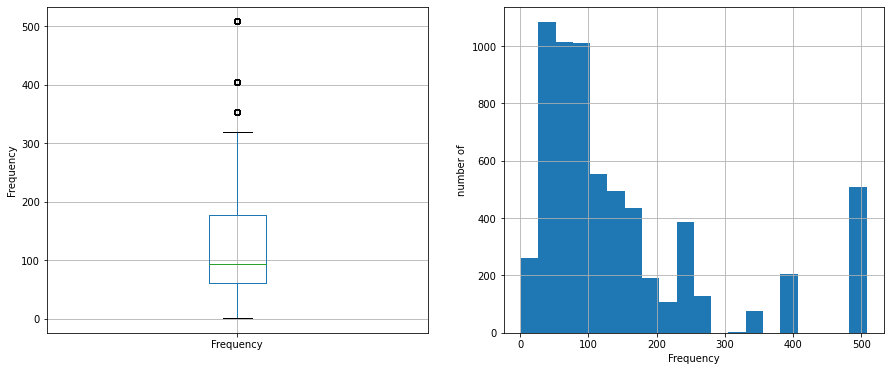

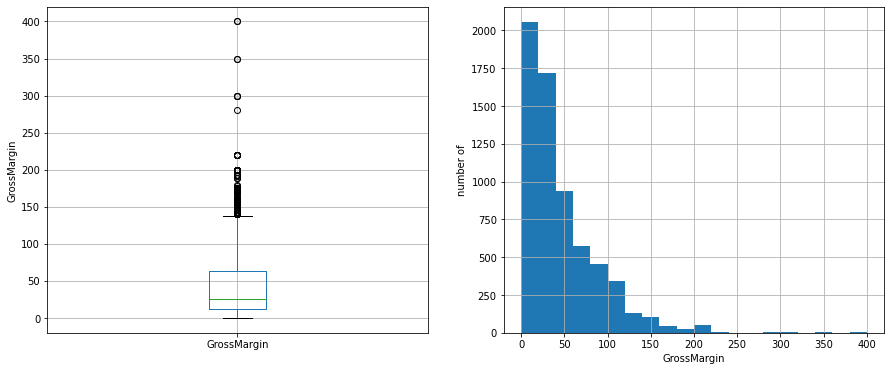

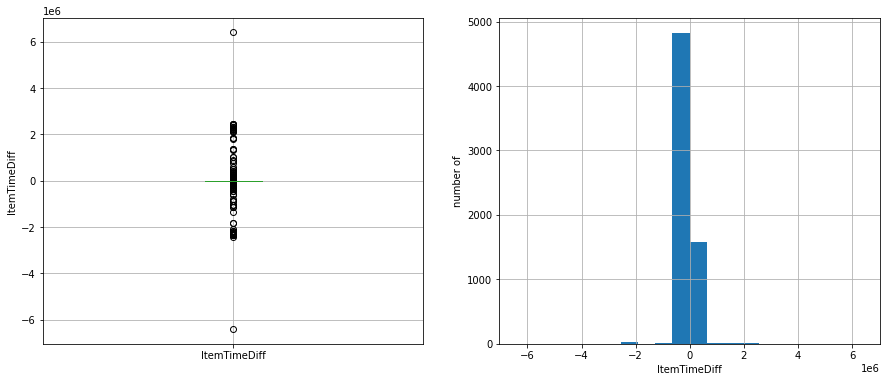

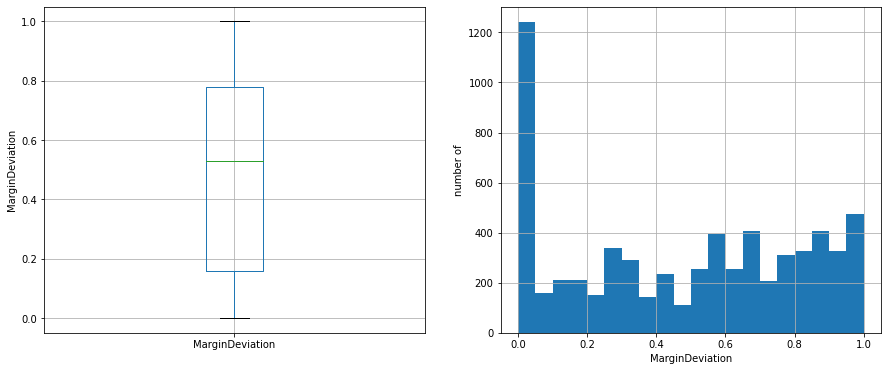

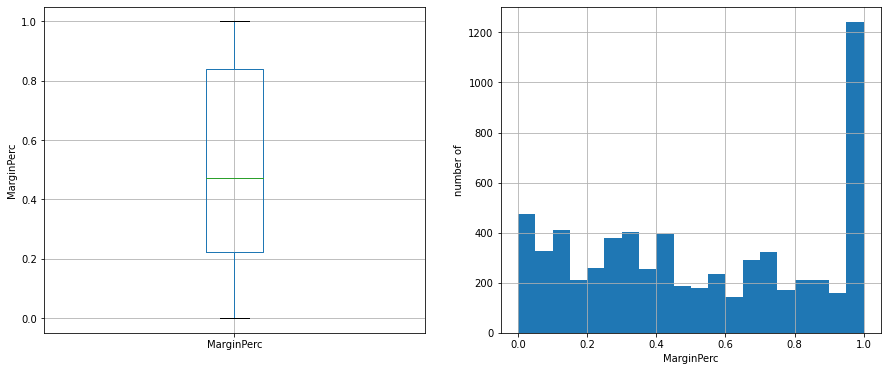

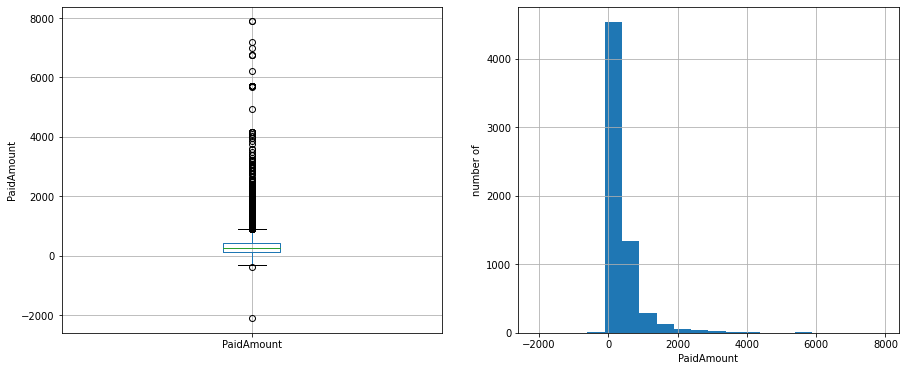

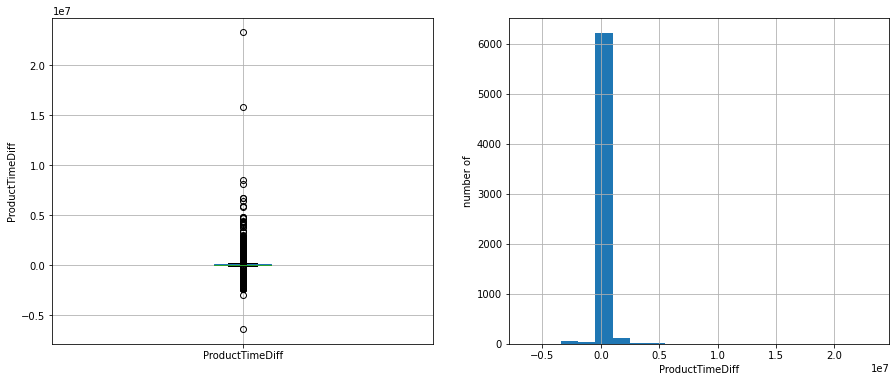

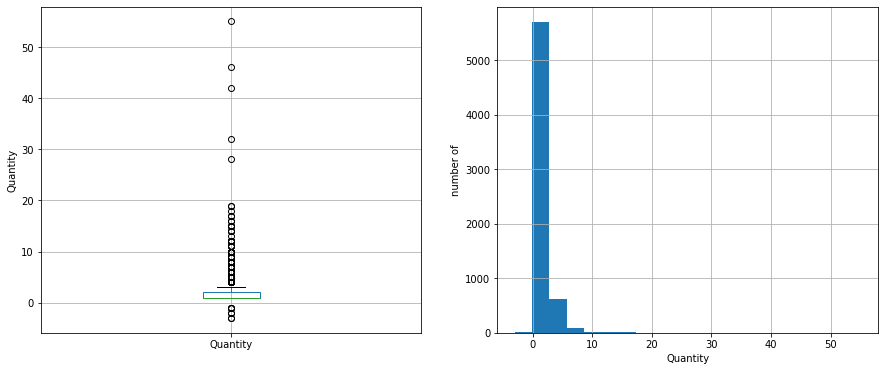

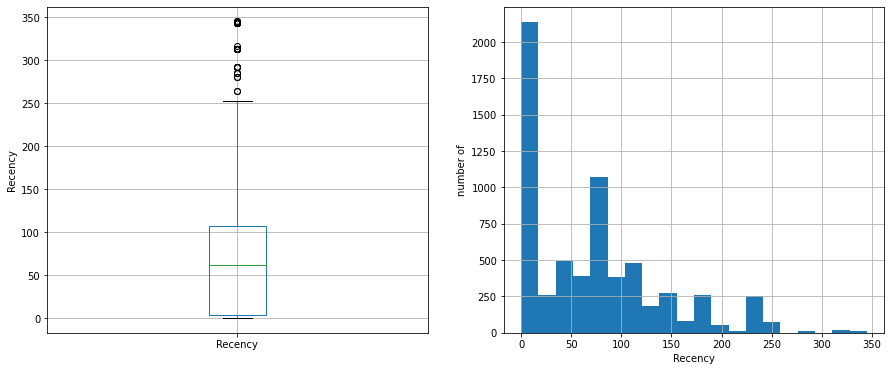

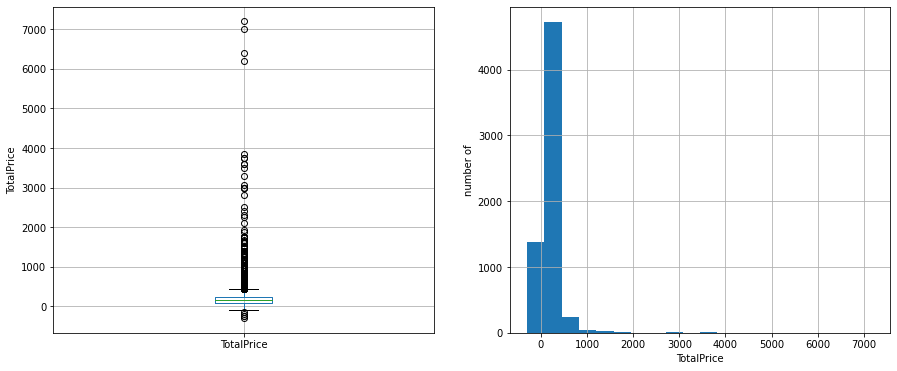

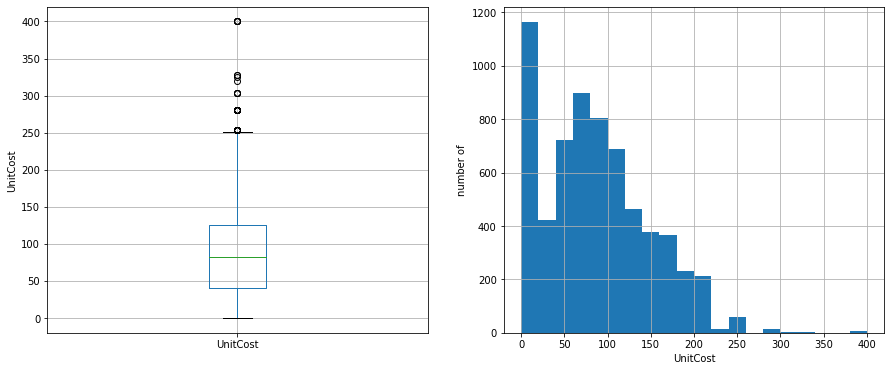

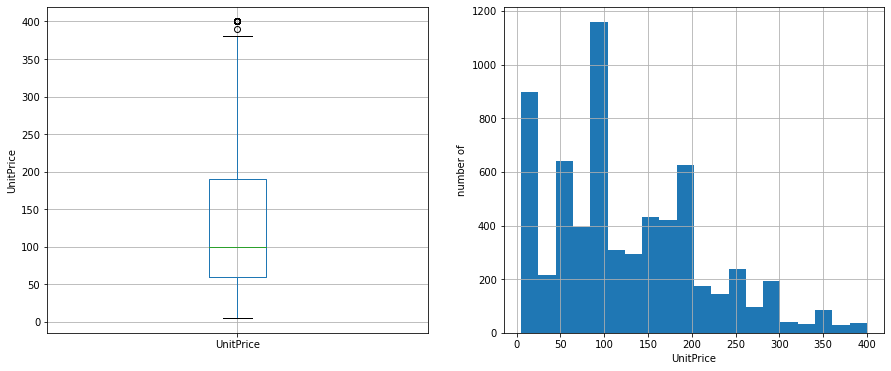

In [36]:
'''visualizing outliers in numerical variables'''
for var in numerical:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = df_tmp.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)

    plt.subplot(1, 2, 2)
    fig = df_tmp[var].hist(bins=20)
    fig.set_ylabel('number of')
    fig.set_xlabel(var)

    plt.show()

# Feature selection

In [37]:
variances = X.var()
variances.sort_values(ascending=False, inplace=True)
variances.head(10)

ProductTimeDiff    5.180219e+11
ItemTimeDiff       5.318166e+10
PaidAmount         4.949821e+05
TotalPrice         2.611457e+05
UnitCost           1.246659e+05
Frequency          1.815426e+04
GrossMargin        9.728543e+03
Recency            4.823888e+03
Minute             3.090577e+02
WeekOfMonth        2.081215e+02
dtype: float64

In [38]:
corrs = abs(df_tmp.corr()['UnitPrice'])
corrs.sort_values(ascending=False, inplace=True)
corrs.head(10)

UnitPrice      1.000000
UnitCost       0.890672
GrossMargin    0.737017
Frequency      0.599025
TotalPrice     0.451374
PaidAmount     0.225894
WeekOfMonth    0.085215
Month          0.083032
Recency        0.076573
Quantity       0.072659
Name: UnitPrice, dtype: float64

In [39]:
abs(df_tmp.corr()["UnitPrice"][abs(df_tmp.corr()["UnitPrice"])>0.5].drop('UnitPrice')).index.tolist()

['Frequency', 'GrossMargin', 'UnitCost']

In [40]:
cv = KFold(n_splits=10, random_state=0, shuffle=False)

pca = decomposition.PCA()

elasticnet = linear_model.ElasticNet()

model = Pipeline(steps=[('scaler', MinMaxScaler()),
                        ('pca', pca),
                        ('elasticnet', elasticnet)])

vals = [0.1,0.2,0.3,0.4,0.5,0.6]
for val in vals:
    features = abs(df_tmp.corr()["UnitPrice"][abs(df_tmp.corr()["UnitPrice"])>val].drop('UnitPrice')).index.tolist()

    X = df_tmp.drop(columns='UnitPrice')
    y = df_tmp.UnitPrice
    X=X[features]

    print(features)

    y_pred = cross_val_predict(model, X, y, cv=cv)
    print("RMSE: " + str(round(sqrt(mean_squared_error(y,y_pred)),2)))
    print("R_squared: " + str(round(r2_score(y,y_pred),2)))

/Users/erickamau/PycharmProjects/ADS/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



['Frequency', 'GrossMargin', 'PaidAmount', 'TotalPrice', 'UnitCost']
RMSE: 80.23
R_squared: 0.15
['Frequency', 'GrossMargin', 'PaidAmount', 'TotalPrice', 'UnitCost']
RMSE: 80.23
R_squared: 0.15
['Frequency', 'GrossMargin', 'TotalPrice', 'UnitCost']
RMSE: 80.26
R_squared: 0.15
['Frequency', 'GrossMargin', 'TotalPrice', 'UnitCost']
RMSE: 80.26
R_squared: 0.15
['Frequency', 'GrossMargin', 'UnitCost']
RMSE: 80.3
R_squared: 0.15
['GrossMargin', 'UnitCost']
RMSE: 83.48
R_squared: 0.08


In [41]:
X = pd.DataFrame(df_tmp[['Frequency', 'MarginDeviation', 'MarginPerc', 'Recency', 'UnitCost', 'ItemTimeDiff', 'ProductTimeDiff']])
y_pred = cross_val_predict(model, X, y, cv=cv)
print("RMSE: " + str(round(sqrt(mean_squared_error(y,y_pred)),2)))
print("R_squared: " + str(round(r2_score(y,y_pred),2)))

RMSE: 81.35
R_squared: 0.13


**Opting to drop 'TotalPrice' and 'GrossMargin' to avoid overfitting the model

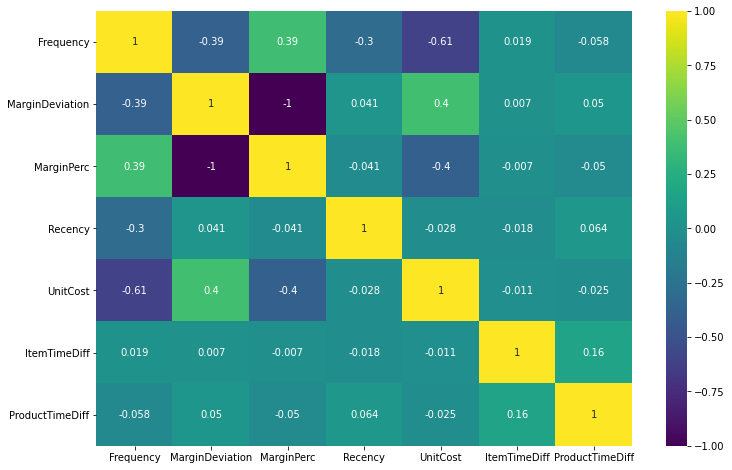

In [42]:
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='viridis')
plt.show()

# Train / Test split

In [43]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5167, 7), (1292, 7), (5167,), (1292,))

In [44]:
'''save train and test datasets to csv'''

X_train.to_csv('train.csv')
X_test.to_csv('test.csv')

 ## Trying out different Regression models

Trying to decide which regression algorithm to go with for our problem
Options:
- Random forest
- Decision tree

In [45]:
%%time

# Instantiate model
rfr = RandomForestRegressor(n_jobs=-1,
                              random_state=42)
# Fit the model
rfr.fit(X_train, y_train)

# Score the model on the training set
print("model score: " + str(rfr.score(X_train, y_train)))
print("cross validation score: " + str(cross_val_score(rfr, X_train, y_train, cv=5)))

model score: 0.9986726135194816
cross validation score: [0.98793586 0.99279949 0.98522913 0.98953189 0.99080596]
CPU times: user 1.87 s, sys: 190 ms, total: 2.06 s
Wall time: 6.16 s


In [46]:
%%time

dtr = DecisionTreeRegressor(criterion="mse",
                              splitter="best",
                              random_state=42)

# Fit the model
dtr.fit(X_train, y_train)

# Score the model on the training set
print("model score: " + str(dtr.score(X_train, y_train)))
print("cross validation score: " + str(cross_val_score(dtr, X_train, y_train, cv=5)))

model score: 1.0
cross validation score: [0.9830832  0.98782549 0.97777607 0.99165106 0.98834655]
CPU times: user 109 ms, sys: 3.8 ms, total: 113 ms
Wall time: 114 ms


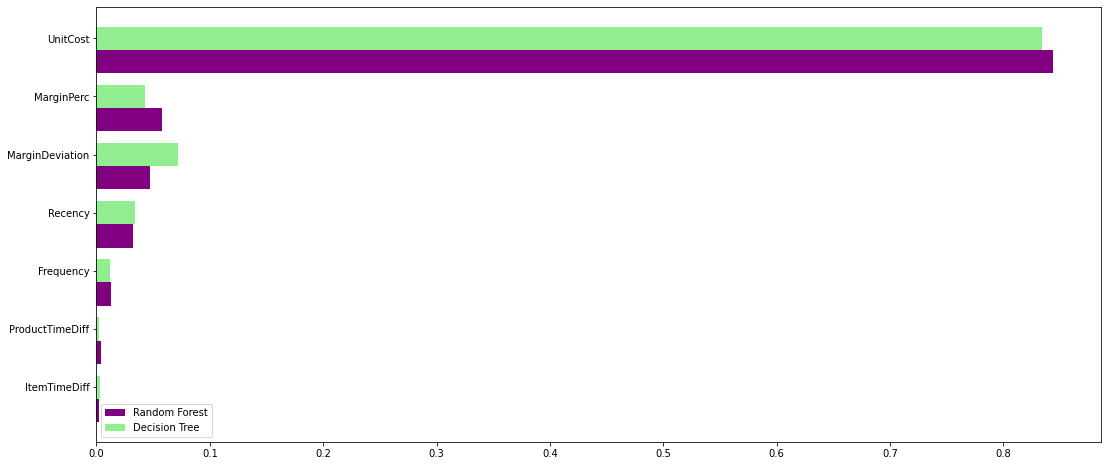

In [47]:
'''visualizing the feature importance as per both models'''

ml_feature_importance = pd.DataFrame({'rfr': rfr.feature_importances_,
                                      'dtr': dtr.feature_importances_},
                                     index=X.columns)
ml_feature_importance.sort_values(by='rfr', ascending=True, inplace=True)

index = np.arange(len(ml_feature_importance))
fig, ax = plt.subplots(figsize=(18,8))
rfr_feature = ax.barh(index, ml_feature_importance['rfr'], 0.4,color='purple', label='Random Forest')
dtr_feature = ax.barh(index+0.4, ml_feature_importance['dtr'], 0.4, color='lightgreen', label='Decision Tree')
ax.set(yticks=index+0.4, yticklabels=ml_feature_importance.index)

ax.legend()
plt.show()

Opting to go for a RandomForestRegressor to predict unit price for items.

Building an evaluation function

In [48]:
# Create evaluation function (the competition uses RMSLE)

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_test, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_test, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_test, val_preds)}
    return scores

# Fitting and evaluating the model

Testing our model on a subset (to tune the hyperparameters)

In [49]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              min_samples_leaf=3000)

In [50]:
%%time
model.fit(X_train, y_train)


CPU times: user 141 ms, sys: 21.3 ms, total: 163 ms
Wall time: 143 ms


RandomForestRegressor(min_samples_leaf=3000, n_jobs=-1, random_state=42)

In [51]:
show_scores(model)

{'Training MAE': 71.28553906921255,
 'Valid MAE': 71.66861318794372,
 'Training RMSLE': 0.9242253209865294,
 'Valid RMSLE': 0.9431366906325973,
 'Training R^2': -1.6676547767158212e-06,
 'Valid R^2': -5.826785680884683e-05}

In [52]:
'''differentiating RandomForestRegressor hyperparameters'''
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]}

'''instantiating the randomized search model'''
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                              random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=cv,
                              verbose=True)

'''fitting the randomized search model'''
rs_model.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.4s finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=False),
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [53]:
# find best params
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 1,
 'max_depth': None}

In [54]:
# evaluate the random search model
show_scores(rs_model)

{'Training MAE': 6.637811244068348,
 'Valid MAE': 8.78603474142995,
 'Training RMSLE': 0.10995680562290358,
 'Valid RMSLE': 0.13793328174646177,
 'Training R^2': 0.9774835608924323,
 'Valid R^2': 0.9613479257255514}

In [55]:
%%time
'''model with most ideal parameters'''

ideal_model = RandomForestRegressor(n_estimators= 60,
                                    min_samples_split= 12,
                                    min_samples_leaf= 1,
                                    max_features= 'sqrt',
                                    max_depth= None,
                                    n_jobs=-1,
                                    random_state=42)

'''fitting the model'''
ideal_model.fit(X_train, y_train)

CPU times: user 318 ms, sys: 22.7 ms, total: 341 ms
Wall time: 154 ms


RandomForestRegressor(max_features='sqrt', min_samples_split=12,
                      n_estimators=60, n_jobs=-1, random_state=42)

In [56]:
# evaluate ideal model
show_scores(ideal_model)

{'Training MAE': 2.499259232788156,
 'Valid MAE': 3.103538288446641,
 'Training RMSLE': 0.06129161827594976,
 'Valid RMSLE': 0.0756503857540921,
 'Training R^2': 0.9916315709098816,
 'Valid R^2': 0.9891331332436306}

In [57]:
'''running model on test data'''
test_pred = ideal_model.predict(X_test)

In [58]:
ideal_model.feature_importances_

array([0.21364603, 0.09887561, 0.07458354, 0.0772759 , 0.52227654,
       0.00371225, 0.00963012])

In [59]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))

    # plot dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

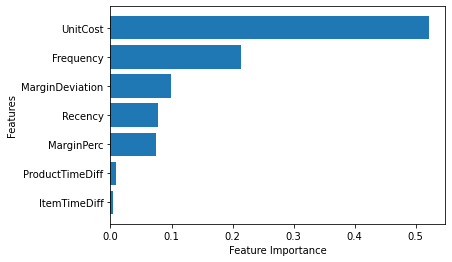

In [60]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [61]:
'''Let's check correlation of values in the train set'''

abs(df_tmp.corr()['UnitPrice'])

Day                      0.006391
DayOfWeek                0.004978
Frequency                0.599025
GrossMargin              0.737017
Hour                     0.028251
ItemTimeDiff             0.020683
MarginDeviation          0.049693
MarginPerc               0.049693
Minute                   0.005060
Month                    0.083032
PaidAmount               0.225894
ProductDiscount          0.002941
ProductDiscountAmount    0.006238
ProductTimeDiff          0.033944
Quantity                 0.072659
Recency                  0.076573
TotalPrice               0.451374
UnitCost                 0.890672
UnitPrice                1.000000
WeekOfMonth              0.085215
PaymentMethod_Cash       0.041859
PaymentMethod_MPESA      0.041859
Name: UnitPrice, dtype: float64

In [62]:
# cv = KFold(n_splits=10, random_state=42)
#
# sfs = SFS(ideal_model,
#           k_features=5,
#           forward=True,
#           scoring="r2",
#           cv=cv)
#
# sfs.fit(X_train, y_train)
# sfs.subsets_

In [63]:
y_pred = cross_val_predict(ideal_model, X, y, cv=cv)
print("RMSE: " + str(round(sqrt(mean_squared_error(y, y_pred)), 3)))
print("R_squared: " +str(round(r2_score(y,y_pred), 3)))

RMSE: 16.734
R_squared: 0.963


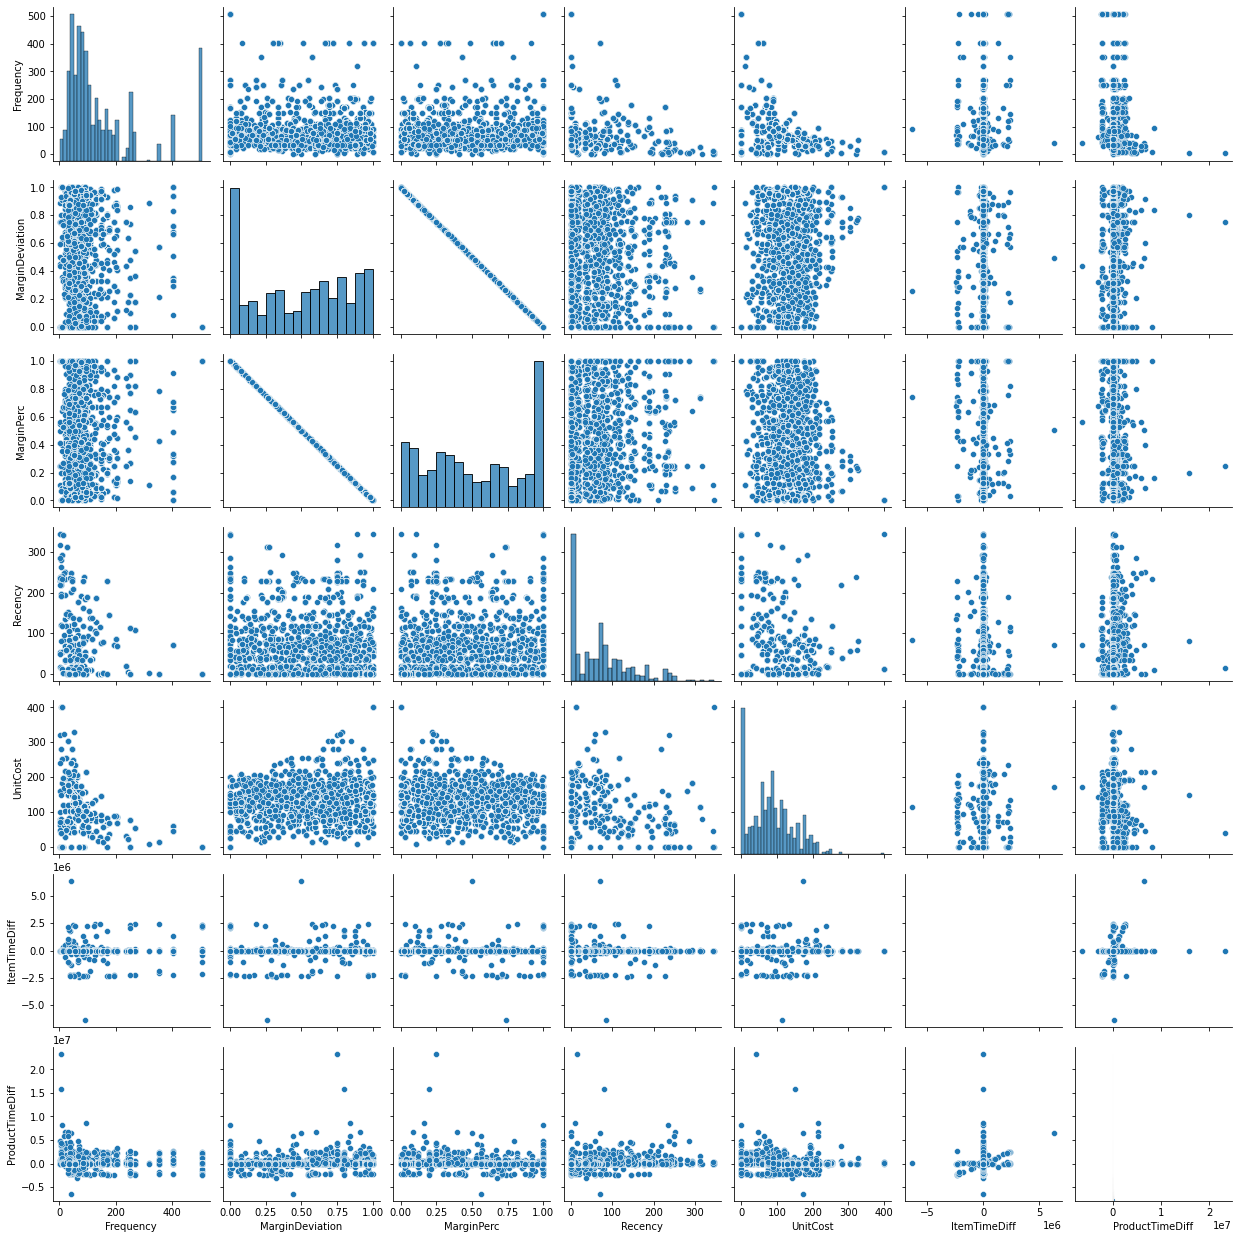

In [64]:
sns.pairplot(X)

Testing unit price predictions

In [67]:
"""unit price predictions from the model"""
y_eval = ideal_model.predict(X_test)
df_eval = pd.DataFrame(y_test.values, columns=["Actual"], index=y_test.index)
df_eval["Predictions"] = pd.Series(np.round(y_eval)).values
df_eval.head(20)


Actual  Predictions
product                                      
Baby bibs feeders           50.0         58.0
Skinny Pants 2             140.0        145.0
Ladies Mix                 120.0        123.0
Fur coats 4                260.0        257.0
Ladies Dress 200bob 2001    99.0        184.0
Children Jackets           150.0        155.0
Tshirt 4                    80.0         81.0
Side pockets               150.0        149.0
Children Set Trousers      100.0        100.0
Drawers                     30.0         30.0
College jackets  3         310.0        299.0
Fagia                       20.0         20.0
Fagia                       20.0         20.0
Denim jackets              200.0        199.0
Skinny Jeans 2             160.0        166.0
Chiffon Tops Long Sleeve    79.0         79.0
Dungaree                   200.0        200.0
paper bags                  10.0         10.0
Denim Shirts               220.0        226.0
Fagia                       20.0         20.0